In [1]:
pip install scikit-fuzzy


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install paho-mqtt

Note: you may need to restart the kernel to use updated packages.


C:\Users\igu1nho\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


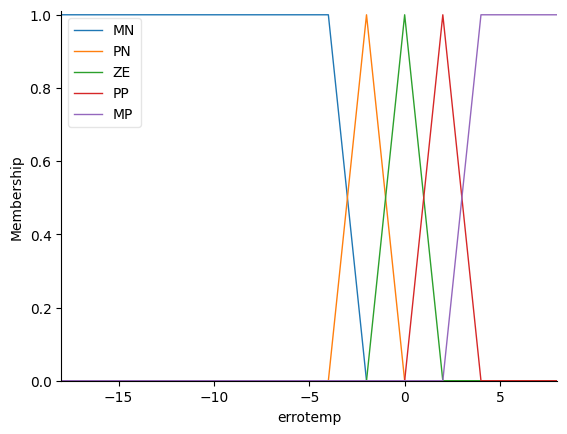

In [3]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time
import requests

# New Antecedent/Consequent objects hold universe variables and membership
# functions
errotemp = ctrl.Antecedent(np.arange(-18, 9, 1), 'errotemp')
varerrotemp =ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'varerrotemp')
aquecedor =ctrl.Consequent(np.arange(0, 101, 1), 'aquecedor')


# Custom membership functions can be built interactively with a familiar,
# Pythonic API
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-18, -18, -4, -2])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-4, -2, 0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-2, 0, 2])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 2, 4])
errotemp['MP'] = fuzz.trapmf(errotemp.universe, [2, 4, 8, 8])
# You can see how these look with .view()
errotemp.view()

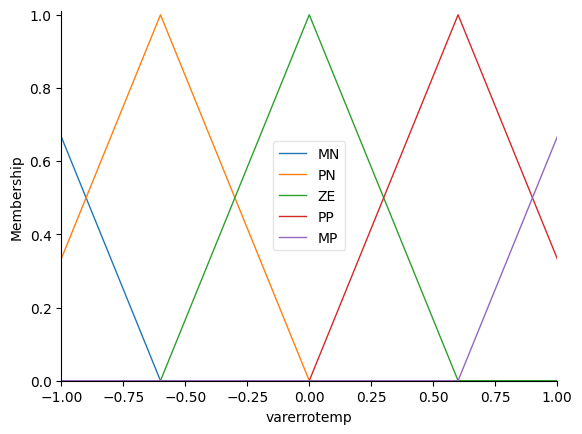

In [4]:
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-4, -4, -1.2, -0.6])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-1.2, -0.6, 0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.6, 0, 0.6])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.6, 1.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe, [0.6, 1.2, 4, 4])
# You can see how these look with .view()
varerrotemp.view()

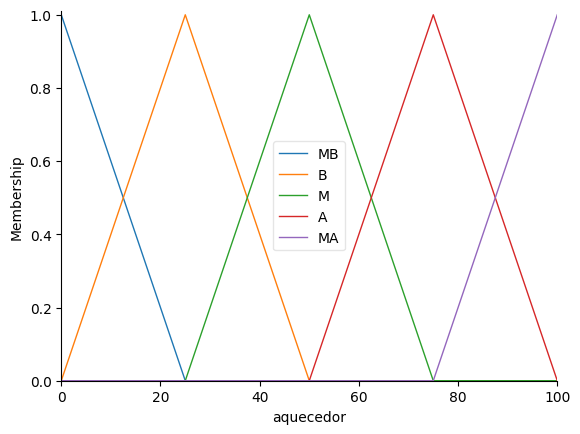

In [5]:
aquecedor['MB'] = fuzz.trimf(aquecedor.universe, [0,0,25])
aquecedor['B'] = fuzz.trimf(aquecedor.universe, [0,25,50])
aquecedor['M'] = fuzz.trimf(aquecedor.universe, [25, 50, 75])
aquecedor['A'] = fuzz.trimf(aquecedor.universe, [50, 75, 100])
aquecedor['MA'] = fuzz.trimf(aquecedor.universe, [75, 100, 100])
aquecedor.view()

In [6]:
regra1 = ctrl.Rule(errotemp['MN'] & varerrotemp['MN'], aquecedor['MA'])
regra2 = ctrl.Rule(errotemp['PN'] & varerrotemp['MN'], aquecedor['MA'])
regra3 = ctrl.Rule(errotemp['ZE'] & varerrotemp['MN'], aquecedor['A'])
regra4 = ctrl.Rule(errotemp['PP'] & varerrotemp['MN'], aquecedor['M'])
regra5 = ctrl.Rule(errotemp['MP'] & varerrotemp['MN'], aquecedor['B'])
regra6 = ctrl.Rule(errotemp['MN'] & varerrotemp['PN'], aquecedor['MA'])
regra7 = ctrl.Rule(errotemp['PN'] & varerrotemp['PN'], aquecedor['A'])
regra8 = ctrl.Rule(errotemp['ZE'] & varerrotemp['PN'], aquecedor['M'])
regra9 = ctrl.Rule(errotemp['PP'] & varerrotemp['PN'], aquecedor['M'])
regra10 = ctrl.Rule(errotemp['MP'] & varerrotemp['PN'], aquecedor['B'])
regra11 = ctrl.Rule(errotemp['MN'] & varerrotemp['ZE'], aquecedor['MA'])
regra12 = ctrl.Rule(errotemp['PN'] & varerrotemp['ZE'], aquecedor['A'])
regra13 = ctrl.Rule(errotemp['ZE'] & varerrotemp['ZE'], aquecedor['M'])
regra14 = ctrl.Rule(errotemp['PP'] & varerrotemp['ZE'], aquecedor['M'])
regra15 = ctrl.Rule(errotemp['MP'] & varerrotemp['ZE'], aquecedor['B'])
regra16 = ctrl.Rule(errotemp['MN'] & varerrotemp['PP'], aquecedor['A'])
regra17 = ctrl.Rule(errotemp['PN'] & varerrotemp['PP'], aquecedor['M'])
regra18 = ctrl.Rule(errotemp['ZE'] & varerrotemp['PP'], aquecedor['M'])
regra19 = ctrl.Rule(errotemp['PP'] & varerrotemp['PP'], aquecedor['B'])
regra20 = ctrl.Rule(errotemp['MP'] & varerrotemp['PP'], aquecedor['MB'])
regra21 = ctrl.Rule(errotemp['MN'] & varerrotemp['MP'], aquecedor['A'])
regra22 = ctrl.Rule(errotemp['PN'] & varerrotemp['MP'], aquecedor['M'])
regra23 = ctrl.Rule(errotemp['ZE'] & varerrotemp['MP'], aquecedor['M'])
regra24 = ctrl.Rule(errotemp['PP'] & varerrotemp['MP'], aquecedor['MB'])
regra25 = ctrl.Rule(errotemp['MP'] & varerrotemp['MP'], aquecedor['MB'])

In [7]:
aquecedor_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
potencia = ctrl.ControlSystemSimulation(aquecedor_ctrl)

In [10]:
sp=-2
tempatual=1
print(tempatual)
erroatual=0
while True: 
  erroanterior = erroatual
  erroatual = tempatual - sp
  varerroTemp = erroatual - erroanterior

  if abs(erroatual) < 0.1:
      break

  potencia.input['errotemp'] = erroatual
  potencia.input['varerrotemp'] = varerroTemp
  potencia.compute()

  for i in range(10):
    ajuste = potencia.output['aquecedor'] * 0.0003963
    tempatual = tempatual * 0.9952 - ajuste
    time.sleep(1)
    i += 1
    
  data = {
        'api_key': 'JS2RAQHE3D15C0GV',
        'field1': tempatual,
        'field2': erroatual
  }
    
  response = requests.post('https://api.thingspeak.com/update', data=data)
    
  print(tempatual)

1
0.8722260166090979
0.680837555265122
0.4907795580926103
0.30242342045639853
0.11414003569922872
-0.07663500503215588
-0.26695925839384044
-0.4483427710742758
-0.6212055465281845
-0.7859478579767134
-0.9429511752619928
-1.0925790481614424
-1.2351779482071867
-1.371078070959858
-1.500594100594494
-1.624025938568976
-1.7416593980622732
-1.8537668657905109
-1.9606079327333221
